In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = 'resp'
ds_folder = f'/mnt/data2/chaoyue/data/cleaned_data'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_node.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_TB_edge.csv
/mnt/data2/chaoyue/data/cleaned_data/cleaned_resp_node.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [3]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_node.csv')
edge_df = pd.read_csv(f'{ds_folder}/cleaned_{ds_name}_edge.csv')

In [4]:
# change the dynamic of background nodes to bg
impute_node = np.where(node_df['cluster_id']=='Background')
node_df = node_df.reset_index(drop=True)
node_df.loc[(impute_node[0]),'dynamic']='bg'
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-01-16,1.0
1,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-20,732.0
2,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-31,100.0
3,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-04-15,444.0
4,10000,Background,A,bg,0.0,1707.680000,1707.0,96.0,457.476318,96.003150,30267.0,-3.419781,197.874194,0.872340,5223.372073,convex_concave,0.324956,3.0,2020-03-25,2154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712625,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,530.0
31712626,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-04,1887.0
31712627,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-04-02,2155.0
31712628,99,c5,E,static,0.0,0.545592,62.0,31.0,-1.181599,31.010421,263.0,0.550453,1.530979,0.266667,15.007554,convex_concave,0.320000,-0.5,2020-03-30,2154.0


In [5]:
edge_df

,from,to,weight1,weight2,sim
0,2143,1,1,0.000878,10000
1,2143,2144,9,0.007498,10000
2,2144,2145,3,0.002609,10000
3,2145,2146,2,0.001815,10000
4,2146,2147,8,0.006459,10000
...,...,...,...,...,...
31704141,3678,622,11,0.008947,99
31704142,3678,737,11,0.010966,99
31704143,3677,3679,7,0.006341,99
31704144,3679,1093,10,0.009722,99


In [6]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (31712630, 20)
Shape of edge data is (31704146, 5)


In [7]:
#information about the node data set
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31704146 entries, 0 to 31704145
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 1.2 GB


In [8]:
edge_df.describe()

,from,to,weight1,weight2,sim
count,3.170415e+07,3.170415e+07,3.170415e+07,3.170415e+07,3.170415e+07
mean,2.851111e+03,1.876277e+03,8.143036e+00,7.328745e-03,5.021782e+03
std,5.494048e+02,1.091097e+03,6.602816e+00,5.973101e-03,2.882530e+03
min,1.630000e+03,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.392000e+03,9.350000e+02,3.000000e+00,2.698795e-03,2.527000e+03
50%,2.841000e+03,1.869000e+03,7.000000e+00,5.924401e-03,5.038000e+03
75%,3.290000e+03,2.804000e+03,1.200000e+01,1.047451e-02,7.507000e+03
max,4.634000e+03,4.634000e+03,9.000000e+01,8.508415e-02,1.000000e+04


### Count number of trees

In [9]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 8484


### Analysis the edge weights

In [10]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [11]:
aly_edge_df.describe()

,weight1,weight2
count,3.170415e+07,3.170415e+07
mean,8.143036e+00,7.328745e-03
std,6.602816e+00,5.973101e-03
min,0.000000e+00,0.000000e+00
25%,3.000000e+00,2.698795e-03
50%,7.000000e+00,5.924401e-03
75%,1.200000e+01,1.047451e-02
max,9.000000e+01,8.508415e-02


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

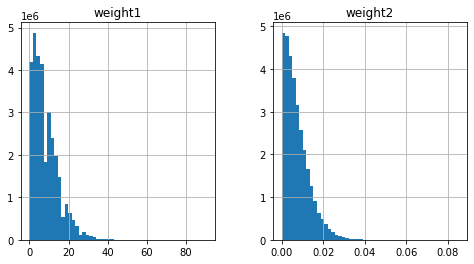

In [12]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [13]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_edge_df.corr()

,weight1,weight2
weight1,1.00000,0.99485
weight2,0.99485,1.00000


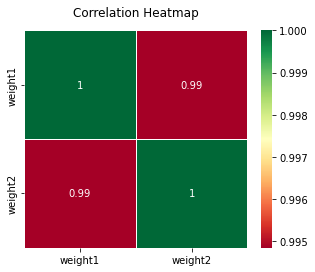

In [14]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(5, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_edge_df.corr(), annot=True, linewidths=.5, cmap="RdYlGn")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', pad=14);

### Get the node and edge distribution of the trees

In [15]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 8484


In [16]:
from collections import defaultdict

tree_dist_dict = defaultdict(list)

for tree_id in tree_ids:
    tree_dist_dict['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    tree_dist_dict['num_nodes'].append(num_nodes)
    
    num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        tree_dist_dict[f'num_{label}_nodes'].append(num_label_nodes)
        tree_dist_dict[f'rat_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    tree_dist_dict['num_edges'].append(onetree_edge_df.shape[0])
    
tree_dist_df = pd.DataFrame.from_dict(tree_dist_dict)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_background_nodes'}>],
       [<AxesSubplot:title={'center':'rat_background_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>,
        <AxesSubplot:title={'center':'rat_static_nodes'}>],
       [<AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'rat_growth_nodes'}>,
        <AxesSubplot:title={'center':'num_decay_nodes'}>],
       [<AxesSubplot:title={'center':'rat_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>, <AxesSubplot:>]],
      dtype=object)

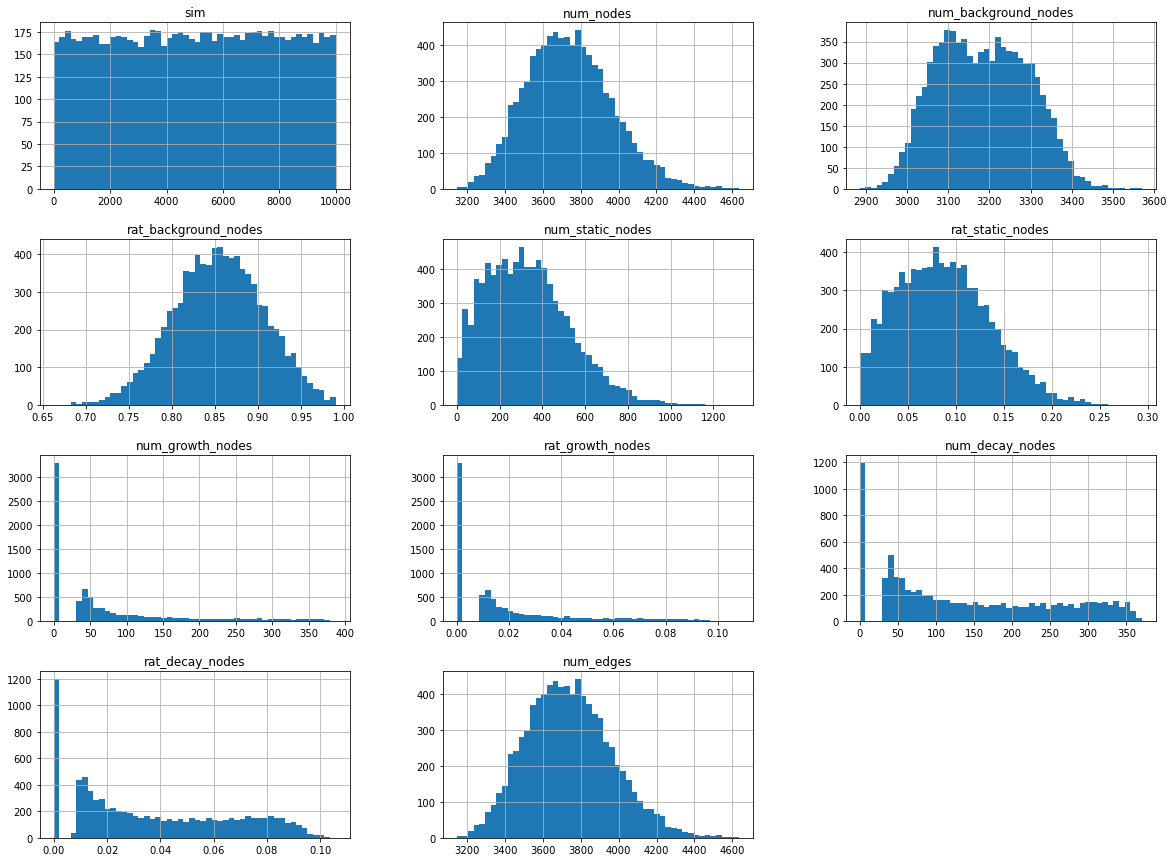

In [17]:
tree_dist_df.hist(bins=50,figsize=(20,15))

### Split the train/test sets

In [18]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'/mnt/data2/chaoyue/data/{ds_name}-classification/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 6787, Test: 1697
[8265 6760 3896 5030 8650 3934 8372 2086 4177 5260]


In [19]:
train_edge_df = edge_df[edge_df['sim'].isin(train_ids)]
test_edge_df = edge_df[edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 25355593
Test edges: 6348553


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

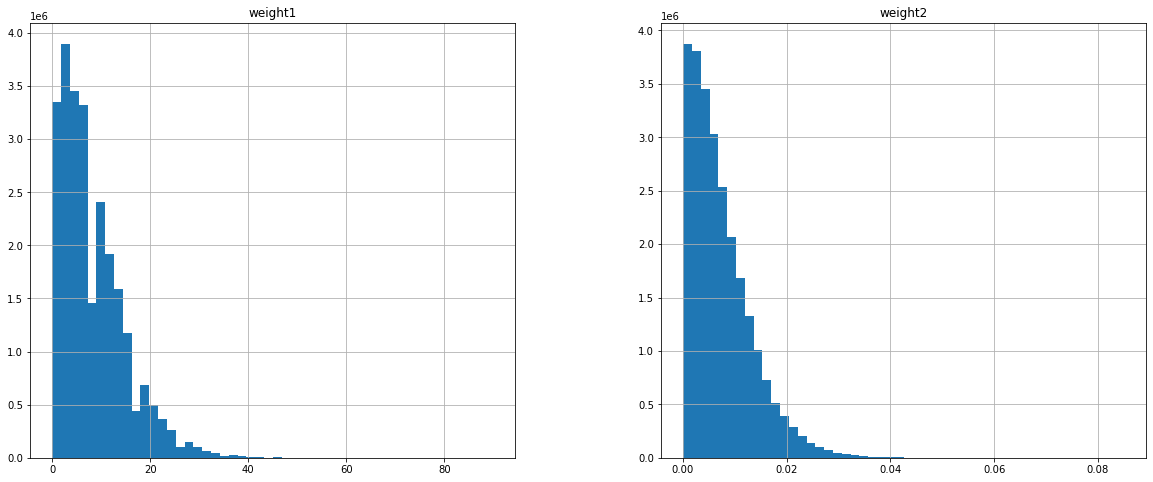

In [20]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

/home/chaoyue/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


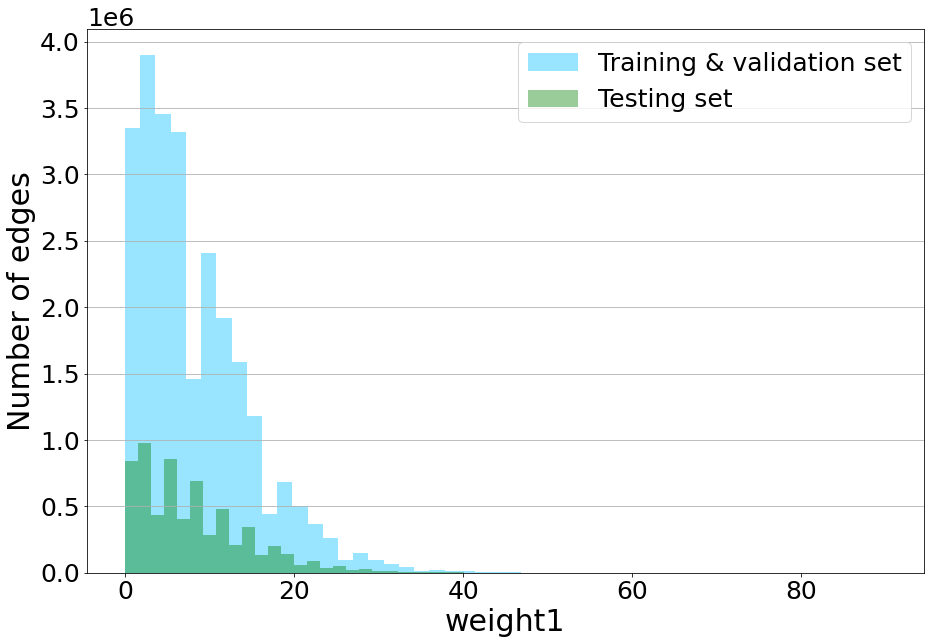

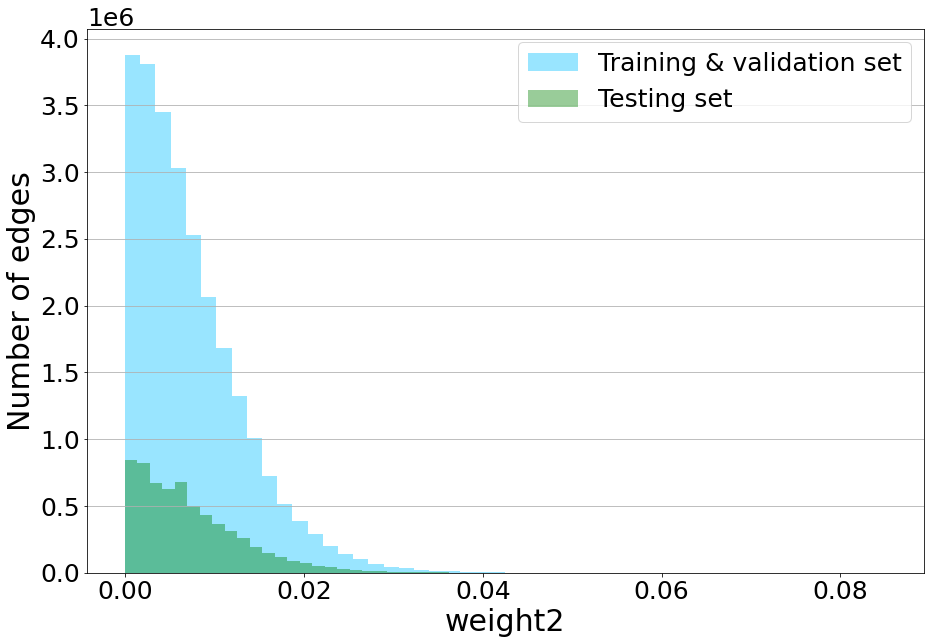

In [21]:
#generate figure plots
for feat in aly_edge_feat_cols:
    fig = plt.figure(figsize=[15,10])
    plt.rcParams.update({'font.size': 25})
    ax1 = fig.add_subplot(111)
    #ax2 = ax1.twinx()
    sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
    sns.distplot(test_edge_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
    #ax2.set(ylim=(0,1.1))
    ax1.axes.set_ylabel("Number of edges",fontsize=30)
    ax1.axes.set_xlabel(f"{feat}",fontsize=30)
    plt.grid(axis = "y")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
    #fig.savefig(f"../paper/edge_dist/{feat}.svg",dpi=600,format='svg')

In [21]:
train_edge_df['weight1'].describe()

count    2.535559e+07
mean     8.150502e+00
std      6.609422e+00
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.200000e+01
max      9.000000e+01
Name: weight1, dtype: float64

In [22]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

/home/chaoyue/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [23]:
train_edge_df['weight2'].describe()

count    2.535559e+07
mean     7.335484e-03
std      5.979120e-03
min      0.000000e+00
25%      2.700436e-03
50%      5.927548e-03
75%      1.048288e-02
max      8.508415e-02
Name: weight2, dtype: float64

In [24]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

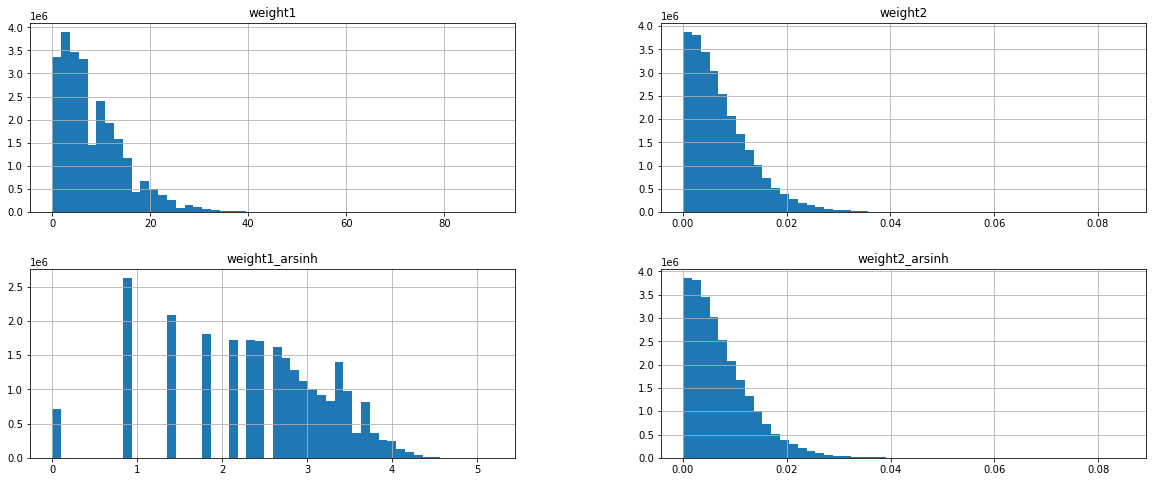

In [25]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [26]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [27]:
train_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,2143,1,1,0.000878,10000,0.881374,0.000878,-1.081865,-1.079937,-1.637167,-1.079992
1,2143,2144,9,0.007498,10000,2.893444,0.007498,0.128528,0.027129,0.487625,0.027161
2,2144,2145,3,0.002609,10000,1.818446,0.002609,-0.779267,-0.790434,-0.647597,-0.790463
3,2145,2146,2,0.001815,10000,1.443635,0.001815,-0.930566,-0.923344,-1.043406,-0.923385
4,2146,2147,8,0.006459,10000,2.776472,0.006459,-0.022771,-0.146578,0.364100,-0.146558
...,...,...,...,...,...,...,...,...,...,...,...
31704141,3678,622,11,0.008947,99,3.093102,0.008946,0.431127,0.269458,0.698469,0.269503
31704142,3678,737,11,0.010966,99,3.093102,0.010966,0.431127,0.607248,0.698469,0.607306
31704143,3677,3679,7,0.006341,99,2.644121,0.006341,-0.174070,-0.166303,0.224334,-0.166284
31704144,3679,1093,10,0.009722,99,2.998223,0.009721,0.279827,0.399062,0.598274,0.399113


In [28]:
print(std_scaler.mean_, std_scaler.scale_)

[8.15050218e+00 7.33548413e-03 2.43168787e+00 7.33523968e-03] [6.60942186e+00 5.97912023e-03 9.46949125e-01 5.97859008e-03]


In [29]:
prep_dict = {}
prep_dict['feat'] = aly_edge_feat_cols
prep_dict['mean'] = std_scaler.mean_
prep_dict['std'] = std_scaler.scale_
prep_dict

{'feat': ['weight1', 'weight2', 'weight1_arsinh', 'weight2_arsinh'],
 'mean': array([8.15050218e+00, 7.33548413e-03, 2.43168787e+00, 7.33523968e-03]),
 'std': array([6.60942186e+00, 5.97912023e-03, 9.46949125e-01, 5.97859008e-03])}

In [30]:
np.save("prep_edge-resp.npy",prep_dict)

In [31]:
# Update the feat_dict.json
import json

js_f = osp.join('./feat_dict-resp.json')

with open(js_f, 'r') as infile:
    feat_dict = json.load(infile)

feat_dict['raw_edge_feats'] = aly_edge_feat_cols
feat_dict['norm_edge_feats'] = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]
feat_dict['norm_edge_feats_arsinh'] = [f'{feat_col}-norm' for feat_col in aly_edge_feat_cols[2:]]

node_feat_cols = feat_dict['norm_onehot_feats']
raw_edge_feat_cols = feat_dict['raw_edge_feats']
norm_edge_feat_cols = feat_dict['norm_edge_feats']

print(f'Inputs: {len(node_feat_cols)}, {node_feat_cols}')
label_feat_col = 'dynamic_cat'

with open(js_f, 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)

Inputs: 16, ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


In [32]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

/home/chaoyue/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh
15080,1957,1958,1,0.000930,1003,0.881374,0.000930
15081,1958,4,24,0.022197,1003,3.871635,0.022196
15082,1958,1959,6,0.004854,1003,2.491780,0.004854
15083,1959,1960,1,0.000866,1003,0.881374,0.000866
15084,1960,1961,1,0.000858,1003,0.881374,0.000858
...,...,...,...,...,...,...,...
31688932,3475,306,5,0.004089,9996,2.312438,0.004089
31688933,3475,1770,11,0.009141,9996,3.093102,0.009140
31688934,3474,3476,5,0.004986,9996,2.312438,0.004986
31688935,3476,602,7,0.006025,9996,2.644121,0.006025


In [33]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

In [34]:
test_edge_df.head()

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
15080,1957,1958,1,0.000930,1003,0.881374,0.000930,-1.081865,-1.071249,-1.637167,-1.071303
15081,1958,4,24,0.022197,1003,3.871635,0.022196,2.398016,2.485624,1.520617,2.485580
15082,1958,1959,6,0.004854,1003,2.491780,0.004854,-0.325369,-0.415036,0.063459,-0.415035
15083,1959,1960,1,0.000866,1003,0.881374,0.000866,-1.081865,-1.082061,-1.637167,-1.082116
15084,1960,1961,1,0.000858,1003,0.881374,0.000858,-1.081865,-1.083409,-1.637167,-1.083464


array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

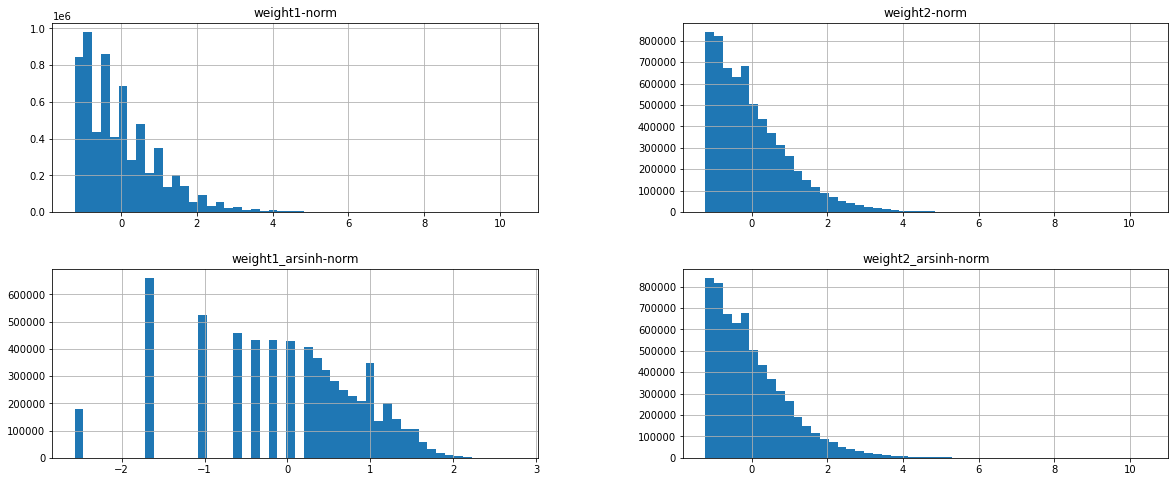

In [35]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

/home/chaoyue/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


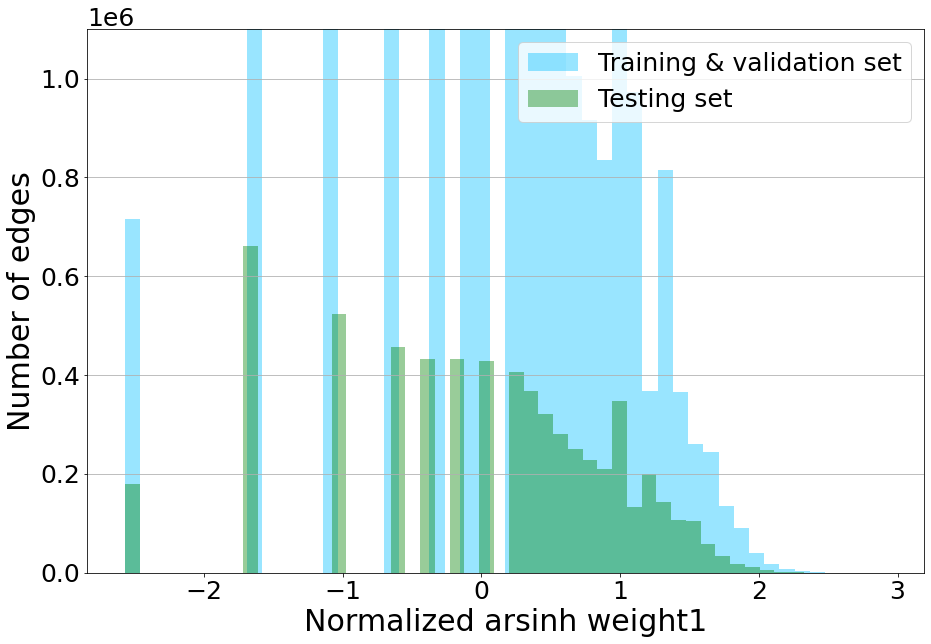

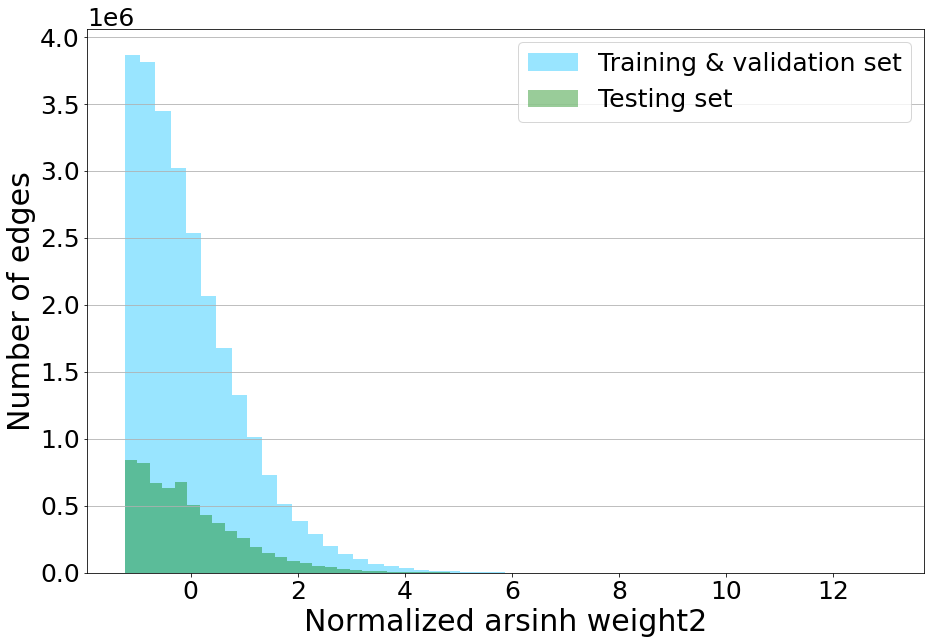

In [37]:
i=1
for feat in norm_edge_feat_cols[2:]:
    fig = plt.figure(figsize=[15,10])
    plt.rcParams.update({'font.size': 25})
    ax1 = fig.add_subplot(111)
    #ax2 = ax1.twinx()
    sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
    sns.distplot(test_edge_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
    if i == 1:
        ax1.set(ylim=(0,1100000))
        i=0
    ax1.axes.set_ylabel("Number of edges",fontsize=30)
    ax1.axes.set_xlabel(f"Normalized arsinh {feat[0:7]}",fontsize=30)
    plt.grid(axis = "y")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
    #fig.savefig(f"../paper/edge_dist/{feat}.svg",dpi=600,format='svg')

In [36]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}")
print(valid_ids[:10])

Train: 5090, Valid: 1697
[4659 8505 8480 3392 9836 4275 9881 6081 2370 3423]


In [37]:
train_full_df = train_edge_df[train_edge_df['sim'].isin(train_ids)]
valid_full_df = train_edge_df[train_edge_df['sim'].isin(valid_ids)]

print(f'Train edge: {train_full_df.shape[0]}')
print(f'Valid edge: {valid_full_df.shape[0]}')
train_full_df.head()

Train edge: 19016575
Valid edge: 6339018


,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,2143,1,1,0.000878,10000,0.881374,0.000878,-1.081865,-1.079937,-1.637167,-1.079992
1,2143,2144,9,0.007498,10000,2.893444,0.007498,0.128528,0.027129,0.487625,0.027161
2,2144,2145,3,0.002609,10000,1.818446,0.002609,-0.779267,-0.790434,-0.647597,-0.790463
3,2145,2146,2,0.001815,10000,1.443635,0.001815,-0.930566,-0.923344,-1.043406,-0.923385
4,2146,2147,8,0.006459,10000,2.776472,0.006459,-0.022771,-0.146578,0.364100,-0.146558


In [38]:
# Save the train/test to the disk

train_full_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
valid_full_df.to_csv(f'{split_folder}/valid_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)

### Tree distribution for train & test sets

In [42]:
from collections import defaultdict
train_dist = defaultdict(list)
all_bg = []
for tree_id in train_ids:
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    if num_nodes == 0:
        all_bg.append(tree_id)
        continue
    train_dist['sim'].append(tree_id)
    train_dist['num_nodes'].append(num_nodes)
    
    num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        train_dist[f'num_{label}_nodes'].append(num_label_nodes)
        train_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)  
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    train_dist['num_edges'].append(onetree_edge_df.shape[0])
    
train_dist_df = pd.DataFrame.from_dict(train_dist)

In [43]:
all_bg

[]

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

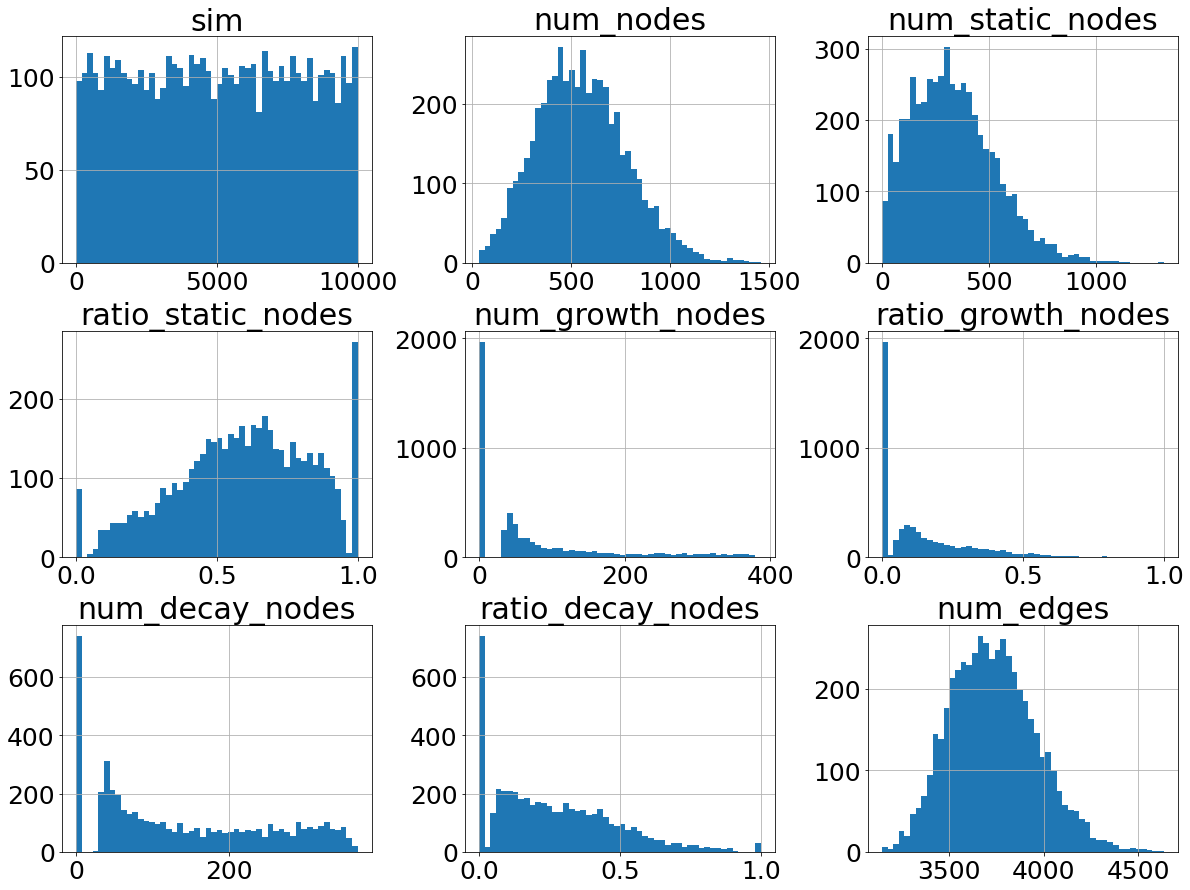

In [44]:
train_dist_df.hist(bins=50,figsize=(20,15))

In [45]:
train_dist_df

,sim,num_nodes,num_static_nodes,ratio_static_nodes,num_growth_nodes,ratio_growth_nodes,num_decay_nodes,ratio_decay_nodes,num_edges
0,7826,831,391,0.470517,168,0.202166,272,0.327316,3843
1,3897,392,254,0.647959,85,0.216837,53,0.135204,3741
2,7505,1077,684,0.635097,319,0.296193,74,0.068709,4166
3,2859,736,473,0.642663,52,0.070652,211,0.286685,3803
4,6780,276,0,0.000000,0,0.000000,276,1.000000,3441
...,...,...,...,...,...,...,...,...,...
5085,1357,253,38,0.150198,0,0.000000,215,0.849802,3496
5086,3806,406,406,1.000000,0,0.000000,0,0.000000,3669
5087,5959,514,359,0.698444,155,0.301556,0,0.000000,3643
5088,8824,604,374,0.619205,62,0.102649,168,0.278146,3933


In [46]:
from collections import defaultdict
test_dist = defaultdict(list)
for tree_id in test_ids:
    test_dist['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    test_dist['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        test_dist[f'num_{label}_nodes'].append(num_label_nodes)
        test_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    test_dist['num_edges'].append(onetree_edge_df.shape[0])
    
test_dist_df = pd.DataFrame.from_dict(test_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

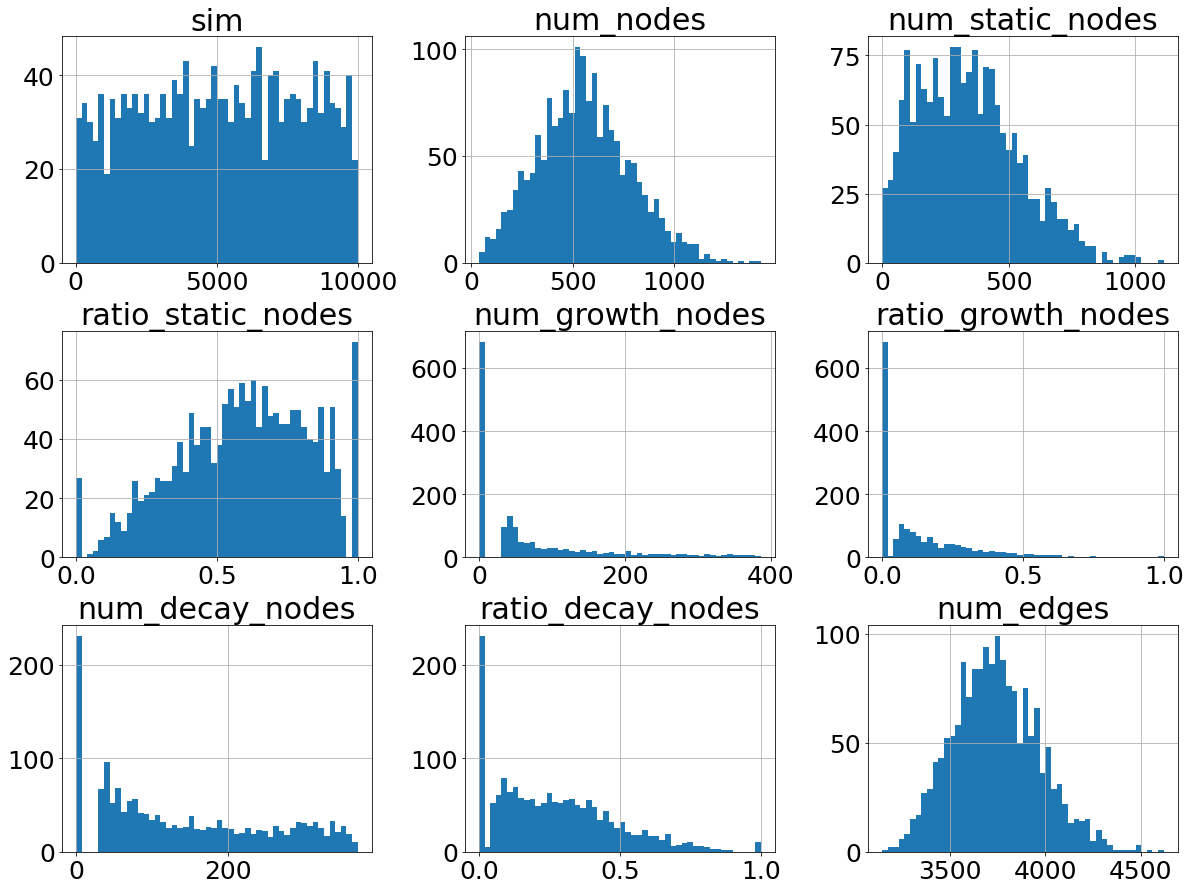

In [47]:
test_dist_df.hist(bins=50,figsize=(20,15))

In [48]:
test_dist_df.columns.values[1:]

array(['num_nodes', 'num_static_nodes', 'ratio_static_nodes',
       'num_growth_nodes', 'ratio_growth_nodes', 'num_decay_nodes',
       'ratio_decay_nodes', 'num_edges'], dtype=object)

/home/chaoyue/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


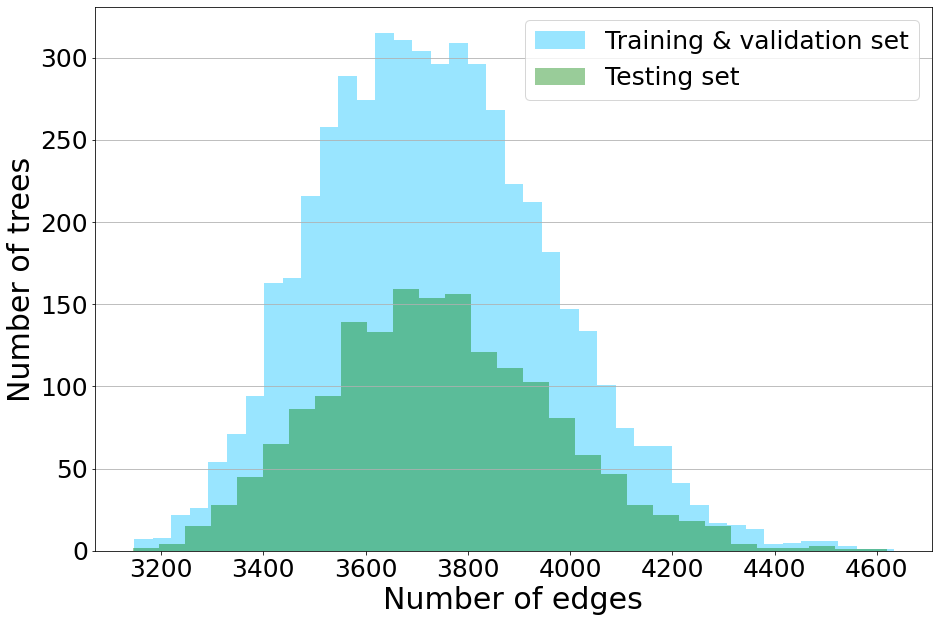

In [49]:
i = 7
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1000))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of edges",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/tree_feat/{feat}.svg",dpi=600,format='svg')

### Build a tree with DGL

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

In [52]:
# Load a tree from the train data
train_node_df = pd.read_csv(f'{split_folder}/train.csv')
vis_tree_id = train_ids[0]
print(vis_tree_id)

5405.0


In [53]:
onetree_node_df = train_node_df[train_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]

/tmp/ipykernel_32458/2451865035.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]


In [54]:
onetree_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,oster,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,new_R0,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
685900,5405.0,c1,B,static,0.0,0.872697,44.0,1.0,111.0,52.246881,111.004883,522.0,1.651867,53.211389,0.0,45.69029,convex,0.263158,0.0,2020-04-08,1937.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651867,1.182087,-0.719233,1.458313,1.458392,-0.628427,-0.011003,-1.249714,-0.027158,-0.327077,-0.51624,-0.394222
685901,5405.0,c1,B,static,0.0,0.872697,44.0,1.0,111.0,52.246881,111.004883,522.0,1.651867,53.211389,0.0,45.69029,convex,0.263158,0.0,2020-04-07,1936.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651867,1.182087,-0.719233,1.458313,1.458392,-0.628427,-0.011003,-1.249714,-0.027158,-0.327077,-0.51624,-0.394222
685902,5405.0,c1,B,static,0.0,0.872697,44.0,1.0,111.0,52.246881,111.004883,522.0,1.651867,53.211389,0.0,45.69029,convex,0.263158,0.0,2020-05-26,125.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651867,1.182087,-0.719233,1.458313,1.458392,-0.628427,-0.011003,-1.249714,-0.027158,-0.327077,-0.51624,-0.394222
685903,5405.0,c1,B,static,0.0,0.872697,44.0,1.0,111.0,52.246881,111.004883,522.0,1.651867,53.211389,0.0,45.69029,convex,0.263158,0.0,2020-04-24,1938.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651867,1.182087,-0.719233,1.458313,1.458392,-0.628427,-0.011003,-1.249714,-0.027158,-0.327077,-0.51624,-0.394222
685904,5405.0,c1,B,static,0.0,0.872697,44.0,1.0,111.0,52.246881,111.004883,522.0,1.651867,53.211389,0.0,45.69029,convex,0.263158,0.0,2020-03-27,29.0,"(-20.742, inf]",2,2,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.651867,1.182087,-0.719233,1.458313,1.458392,-0.628427,-0.011003,-1.249714,-0.027158,-0.327077,-0.51624,-0.394222


In [55]:
onetree_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
10066021,1911,1,1,0.000836,5405,0.881374,0.000836,-1.033461,-1.037620,-1.606488,-1.037732
10066022,1911,1912,24,0.020414,5405,3.871635,0.020413,1.939023,1.759957,1.387783,1.760093
10066023,1912,1913,1,0.000850,5405,0.881374,0.000850,-1.033461,-1.035592,-1.606488,-1.035704
10066024,1913,4,10,0.009050,5405,2.998223,0.009050,0.129685,0.136180,0.513200,0.136239
10066025,1913,1914,3,0.002441,5405,1.818446,0.002441,-0.774984,-0.808172,-0.668158,-0.808248
...,...,...,...,...,...,...,...,...,...,...,...
10069584,3568,36,2,0.001781,5405,1.443635,0.001781,-0.904222,-0.902588,-1.043472,-0.902679
10069585,3568,42,7,0.006671,5405,2.644121,0.006671,-0.258030,-0.203722,0.158623,-0.203707
10069586,1947,3569,10,0.008822,5405,2.998223,0.008822,0.129685,0.103612,0.513200,0.103668
10069587,3569,15,2,0.001729,5405,1.443635,0.001729,-0.904222,-0.910004,-1.043472,-0.910096


In [56]:
pip install pygraphviz==1.5

  Using cached pygraphviz-1.5.zip (117 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/chaoyue/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-w4_8vew4/pygraphviz_d03e9824f5b74897a34ba89ce42eb250/setup.py'"'"'; __file__='"'"'/tmp/pip-install-w4_8vew4/pygraphviz_d03e9824f5b74897a34ba89ce42eb250/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-b2rp14hx
       cwd: /tmp/pip-install-w4_8vew4/pygraphviz_d03e9824f5b74897a34ba89ce42eb250/
  Complete output (58 lines):
  /home/chaoyue/anaconda3/lib/python3.8/site-packages/setuptools/dist.py:717: UserWarning: Usage of dash-separated 'build-requires' will not be supported in future versions. Please use the underscore

Note: you may need to restart the kernel to use updated packages.


In [57]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

Using backend: pytorch


ModuleNotFoundError: No module named 'pygraphviz'

In [ ]:
src_ids = torch.tensor(onetree_edge_df['from'].values)
dst_ids = torch.tensor(onetree_edge_df['to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [ ]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')

In [ ]:
g.nodes()

### Assign features to nodes

In [ ]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

In [ ]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(sorted_onetree_node_df.isnull(), cbar=False)

In [ ]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(sorted_onetree_node_df,labels=True,fontsize=10) 

In [ ]:
g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df[label_feat_col].values)

for i in range(n_nodes):
    if not torch.all(torch.isnan(g.ndata['feat'][i])):
        print(f"NodeID: {i+1}, {g.ndata['feat'][i]}, {g.ndata['label'][i]}")
        break

### Assign features to edges

In [ ]:
g.edges()

In [ ]:
# The edge features are assigned to the edata according to the edge order, not considerring the src and dst
g.edata['feat'] = torch.tensor(onetree_edge_df[norm_edge_feat_cols].values)
g.edata['feat'][0]

In [ ]:
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if np.isnan(node_label):
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)